[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dessia-tech/tutorials/blob/datatools/notebook/datatools.ipynb)

# **Introduction**

# **Installation**

## Initialization (only for Colab users)

In [ ]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py38" --user
!conda update conda -y

In [ ]:
# Reload the web page (quit) and execute this cell
import sys
print("User Current Version:-", sys.version)
if sys.version[:3] != "3.8":
  raise SystemError("Try to reload the web page (quit)")

## Python imports

In [ ]:

!pip install dessia_common

In [ ]:
from dessia_common.core import DessiaObject, DessiaFilter, FiltersList
from dessia_common.models import all_cars_no_feat, all_cars_wi_feat, rand_data_middl
from dessia_common.datatools import HeterogeneousList, CategorizedList

# **Heterogeneous Lists**

A HeterogeneousList is a container object for DessiaObjetcs.

It implements many features that can help engineers exploring data contained in a list. HeterogenenousList includes, among others, a plot_data method, filtering capabilities, data exploration features and can be clustered into a CategorizedList to help clustering similar data.

The current section is a guide for users to prepare data for HeterogeneousList and easy manipulate them once created.

## Description

HeterogeneousList is a class object that inherits from DessiaObject. Thus, any method developed for DessiaObject will work on HeterogeneousList.

It is designed to store a list of any kind of DessiaObjects, potentially from different classes, in a same HeterogeneousList.

Every subclass of DessiaObject can be stored in a HeterogeneousList which possesses only one additional attribute and two properties:
*   *dessia_objects* (attribute): list of DessiaObjects, the data to store and study
*   *common_attributes* (property): common attributes in stored DessiaObjects. Can be defined by user or automatically generated
*   *matrix* (property): matrix of data, $n_{samples} \times n_{features}$


In [ ]:
# Don't run this code
class HeterogeneousList(DessiaObject):
    _standalone_in_db = True
    _vector_features = ["name", "common_attributes"]

    def __init__(self, dessia_objects: List[DessiaObject] = None, name: str = ''):
        if dessia_objects is None:
            dessia_objects = []
        self.dessia_objects = dessia_objects
        DessiaObject.__init__(self, name=name)

    @property
    def common_attributes(self):
      return

    @property
    def matrix(self):
      return

### *dessia_objects*
*dessia_objects* is the list of stored data to study in HeterogeneousList.

### *common_attributes*
By default, *common_attributes* are computed automatically. They are the common numerical attributes between all classes of DessiaObjects in *dessia_objects*. These attributes must be arguments of ```__init__``` method and not standard *DessiaObject* attributes:

```
for arg in args(init):
    if isnumeric(arg) and arg not in attributes(DessiaObject) and arg in all(DessiaObjects):
        common_attributes <- arg
```

This behavior can be customed with `_vector_features` class attributes.

### *matrix*
The property *matrix* is computed with the *common_attributes* and the *to_vector* method of DessiaObjects present in *dessia_objects*.

It is the concatenation of all equivalent vectors of each DessiaObject stored in *dessia_objects*. 

These vectors are computed with the customable *to_vector* method of each DessiaObject. In HeterogeneousList, only dimensions present in *common_attributes* are kept for building the vector. 

Columns of *matrix* are stored in the same order as *common_attributes*.

In [ ]:
# Don't run this code
@property
def matrix(self):
    if self._matrix is None:
        matrix = []
        for dessia_object in self.dessia_objects:
            temp_row = dessia_object.to_vector()
            vector_features = dessia_object.vector_features()
            matrix.append(list(temp_row[vector_features.index(attr)] for attr in self.common_attributes))
        self._matrix = matrix
    return self._matrix

## Create a HeterogeneousList
A HeterogeneousList is created from a list of DessiaObjects and a name (optional).

In [ ]:
from dessia_common.core import DessiaObject
from dessia_common.datatools import HeterogeneousList
class MyObject(DessiaObject):
  def __init__(self, attr, name=''):
    self.attr = attr

my_list = [MyObject(idx) for idx in range(1000)]
my_hlist = HeterogeneousList(my_list, 'example')
print(my_hlist)

## Custom *common_attributes* and *matrix* computation
The list of common attributes generated with standard behavior can be too restrictive. Indeed, sometimes, attributes are not called in `__init__` method but just computed in its script. 

Furthermore, some attributes may not be directly attached to the DessiaObjects to vectorize but to some subobject or a list of data, outside the scope of objects contained in *dessia_objects*. 

To handle such cases, one can respectively modify the class attribute *_vector_features* or the method *to_vector* in the mother classes of instances stored in *dessia_objects*.



### Class attribute *_vector_features*
To specify attributes to compute vectors of DessiaObjects stored in *dessia_objects*, define a *_vector_features* class attribute in objects stored in *dessia_objects*.

In [ ]:
from dessia_common.core import DessiaObject
from dessia_common.datatools import HeterogeneousList
class MyObject(DessiaObject):
  _vector_features = ['attr', 'prop', 'not_in_init']
  def __init__(self, attr, name=''):
    self.attr = attr
    self.not_in_init = 1.5*attr
    DessiaObject.__init__(self, name=name)

  @property
  def prop(self):
    return 4
  
hlist = HeterogeneousList([MyObject(2.3), MyObject(-2), MyObject(25)])
print(hlist.common_attributes)

### Method *to_vector*
Computed values that are not directly DessiaObject attributes can be handled in HeterogeneousList by specifying them in `_vector_features` and customizing the `to_vector` method.
Attributes specified in `_vector_features` must be in the same order as values stored with the `to_vector` method.

In [ ]:
from dessia_common.core import DessiaObject
from dessia_common.datatools import HeterogeneousList
class MyObject(DessiaObject):
  _vector_features = ['attr', 'prop', 'not_in_init', 'in_to_vector']
  def __init__(self, attr, name=''):
    self.attr = attr
    self.not_in_init = 1.5*attr
    DessiaObject.__init__(self, name=name)

  @property
  def prop(self):
    return 4

  def to_vector(self):
    return [self.attr, self.not_in_init, self.prop, self.attr*124]
  
hlist = HeterogeneousList([MyObject(2.3), MyObject(-2), MyObject(25)])
print(hlist.common_attributes)

## Work with HeterogeneousList
HeterogeneousList are designed to facilitate list handling in Dessia workflows, both on platform and in IDEs (local). In that sense, they have customed built-in methods and additional methods to facilitate access to data and measurements.

**Built-in methods:**
*   [`__len__`](https://lien vers la doc)
*   [`__str__`](https://lien vers la doc)
*   [`__getitem__`](https://lien vers la doc)
*   [`__add__`](https://lien vers la doc)
*   [`extend`](https://lien vers la doc)

**Implemented methods:**
*   [`get_attribute_values`](https://lien vers la doc)
*   [`get_column_values`](https://lien vers la doc)
*   [`sort`](https://lien vers la doc)
*   [`mean`](https://lien vers la doc)
*   [`standard_deviation`](https://lien vers la doc)
*   [`variances`](https://lien vers la doc)
*   [`covariance_matrix`](https://lien vers la doc)
*   [`distance_matrix`](https://lien vers la doc)
*   [`filtering`](https://lien vers la doc)
*   [`plot`](https://lien vers la doc)
*   [`pareto_indexes`](https://lien vers la doc)
*   [`pareto_points`](https://lien vers la doc)
*   [`pareto_sheets`](https://lien vers la doc)
*   [`singular_values`](https://lien vers la doc)

## Inherit from HeterogeneousList
HeterogeneousList is a base class to sustain engineers in handling lists of DessiaObjects. It can be used as a parent class to inherit from, in order to use all its standard methods in addition to specific customed methods, attached to its child. 

This can be particularly useful when some standard methods do not work as expected for a special case.


In [ ]:
from dessia_common.core import DessiaObject
from dessia_common.datatools import HeterogeneousList

class MyObject(DessiaObject):
  def __init__(self, attr, name=''):
    self.attr = attr
    DessiaObject.__init__(self, name=name)

class MyHList(HeterogeneousList):
  def __init__(self, dessia_objects: List[MyObject], other_attr, name=''):
    HeterogeneousList.__init__(dessia_objects, name)
    self.other_attr = other_attr

  def my_method(self):
    print("This is a customed method")

  def __str__(self):
    string = HeterogeneousList.__str__()
    list_string = string.split('\n')
    list_string[0] += f', attr = {self.attr}'
    return '\n'.join(list_string)

myhlist = MyHList([MyObject(2.3), MyObject(-2), MyObject(25)], 42, 'name')
myhlist.my_method()
print(myhlist)

# **Tutorial 1: Visualize data with HeterogeneousList**
This tutorial describes the method to create a HeterogeneousList from a list of data and plot it in a web browser.

It also details the procedure to create the equivalent workflow to be stored and ran on Dessia platform.

## Build list of data
HeterogeneousList are useful for handling list of DessiaObjects. First, import packages and create a DessiaObject class.

In [ ]:
import pkg_resources
import numpy as npy

from dessia_common import DessiaObject
from dessia_common.datatools import HeterogeneousList
import dessia_common.typings as dct
from dessia_common.files import StringFile

# Class definition
class Car(DessiaObject):
    _standalone_in_db = True
    _non_data_hash_attributes = ['name']
    _vector_features = ['mpg', 'displacement', 'horsepower', 'weight', 'thrust', 'price'] # Important parameter

    def __init__(self, name: str, mpg: float, cylinders: int, displacement: dct.Distance, horsepower: float,
                 weight: dct.Mass, acceleration: dct.Time, model: int, origin: str):
        DessiaObject.__init__(self, name=name)
        self.mpg = mpg
        self.cylinders = cylinders
        self.displacement = displacement
        self.horsepower = horsepower
        if horsepower == 0: # Avoid 0 horsepower
            self.horsepower = 50.
        self.weight = weight*0.453592 # convert in kg
        self.acceleration = acceleration
        self.model = model
        self.origin = origin

    @classmethod
    def from_csv(cls, file: StringFile, end: int = None, remove_duplicates: bool = False):
        """
        Generates Cars from given .csv file.
        """
        array = [row.split(',') for row in file.getvalue().split('\n')][1:-1]
        cars = []
        for idx_line, line in enumerate(array):
            if end is not None and idx_line >= end:
                break
            if not remove_duplicates or (remove_duplicates and line.tolist() not in cars):
                attr_list = [float(attr) if attr.replace('.', '').isnumeric() else attr for attr in line]
                attr_list[3] /= 1000 # convert displacement in m
    
                for idx_attr, attr in enumerate(attr_list): # replace numpy types
                    if isinstance(attr, npy.int64):
                        attr_list[idx_attr] = int(attr)
                    elif isinstance(attr, npy.float64):
                        attr_list[idx_attr] = float(attr)
                cars.append(cls(*attr_list))
        return cars
        
    @property
    def thrust(self):
      return self.weight*100/self.acceleration/1.609 # dummy example, convert in km
      
    def to_vector(self):
      return [self.mpg, self.displacement, self.horsepower, self.weight, self.thrust,
              self.weight*5*self.horsepower/150] # price is a dummy example

## Store data in HeterogeneousList

In [ ]:
# Import data in a list
csv_cars = pkg_resources.resource_stream('dessia_common', 'models/data/cars.csv')
stream = StringFile.from_stream(csv_cars)
list_mycars = Car.from_csv(stream)

# Create HeterogeneousList of cars
my_hlist = HeterogeneousList(list_mycars)

## Plot HeterogeneousList
To visualize data stored in HeterogeneousList, use the plot method.

It displays numerical data stored in matrix with a parallel plot, a scatter matrix and a dimensionality plot.

In [ ]:
# Plot my_hlist
my_hlist.plot()

### Parallel plot of data
Shows attributes values on parallel axes.

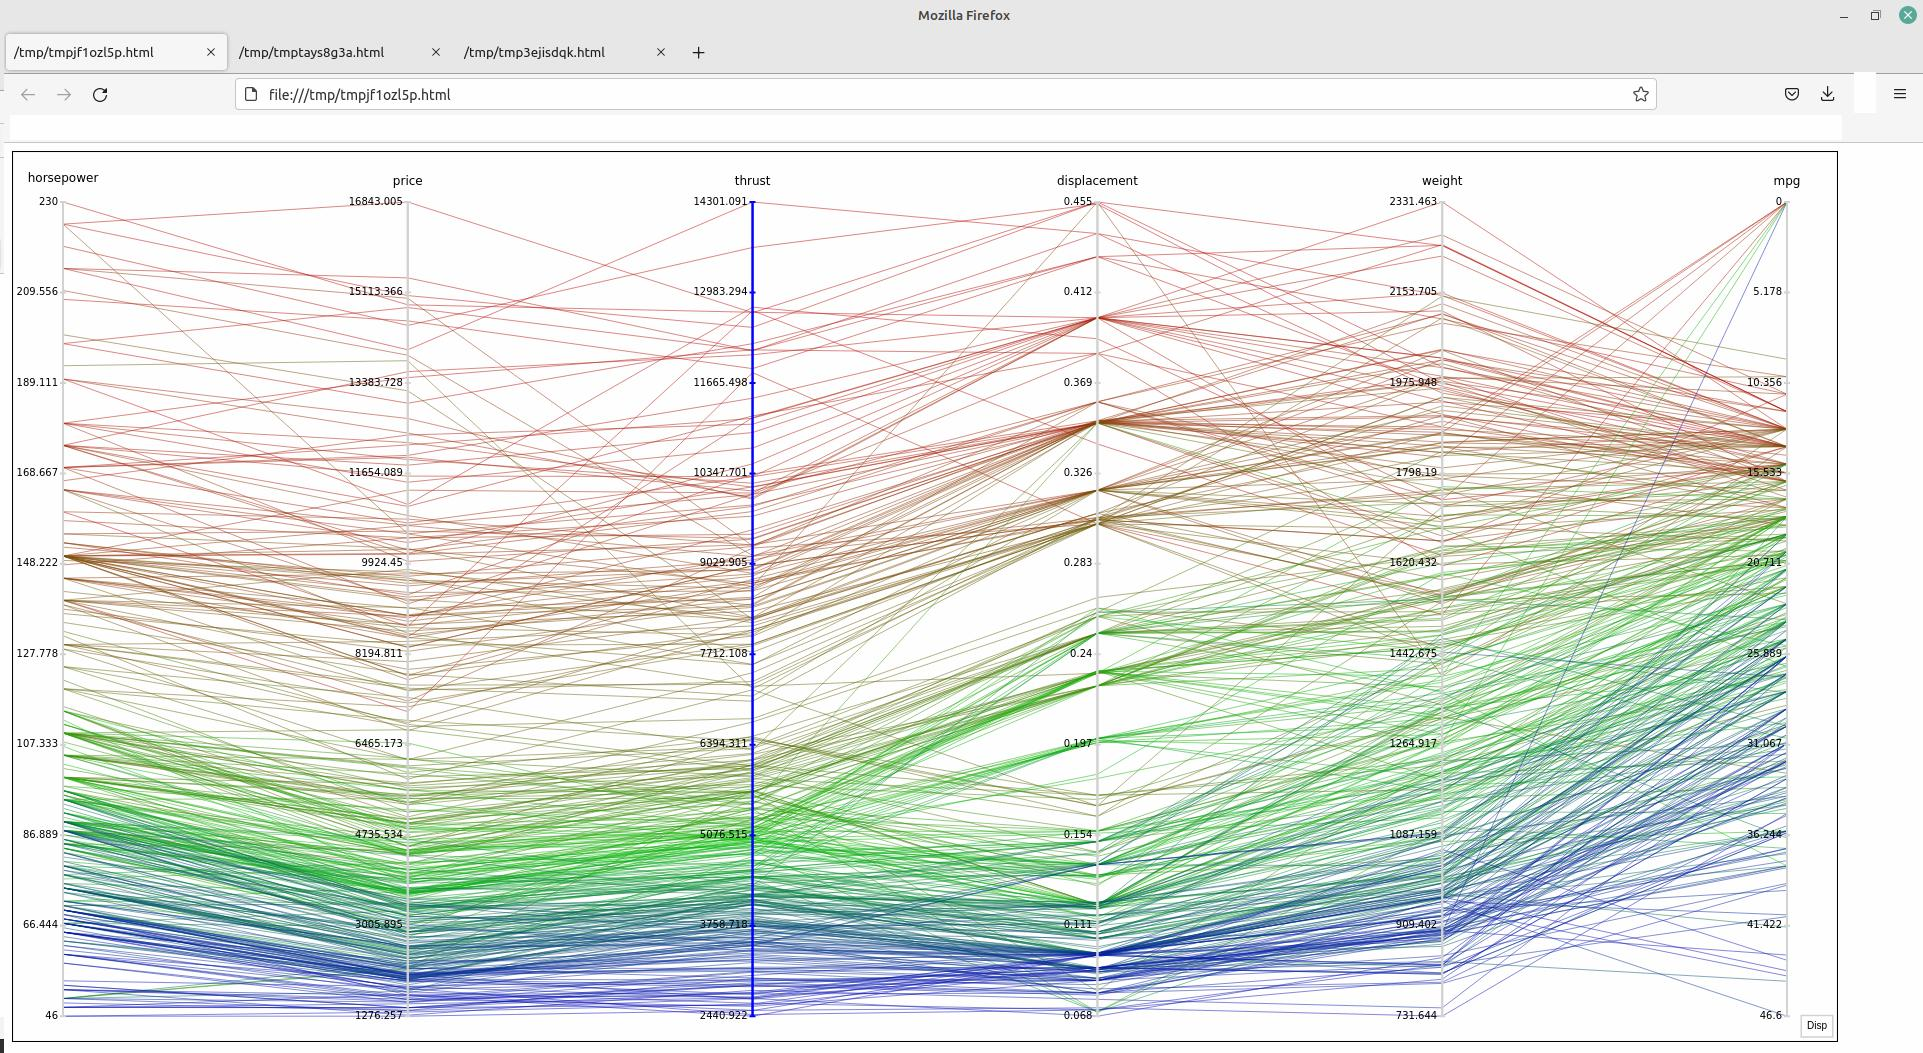

### Scatter matrix of data
Plots all pairwise attributes in scatters so that correlations can be seen.

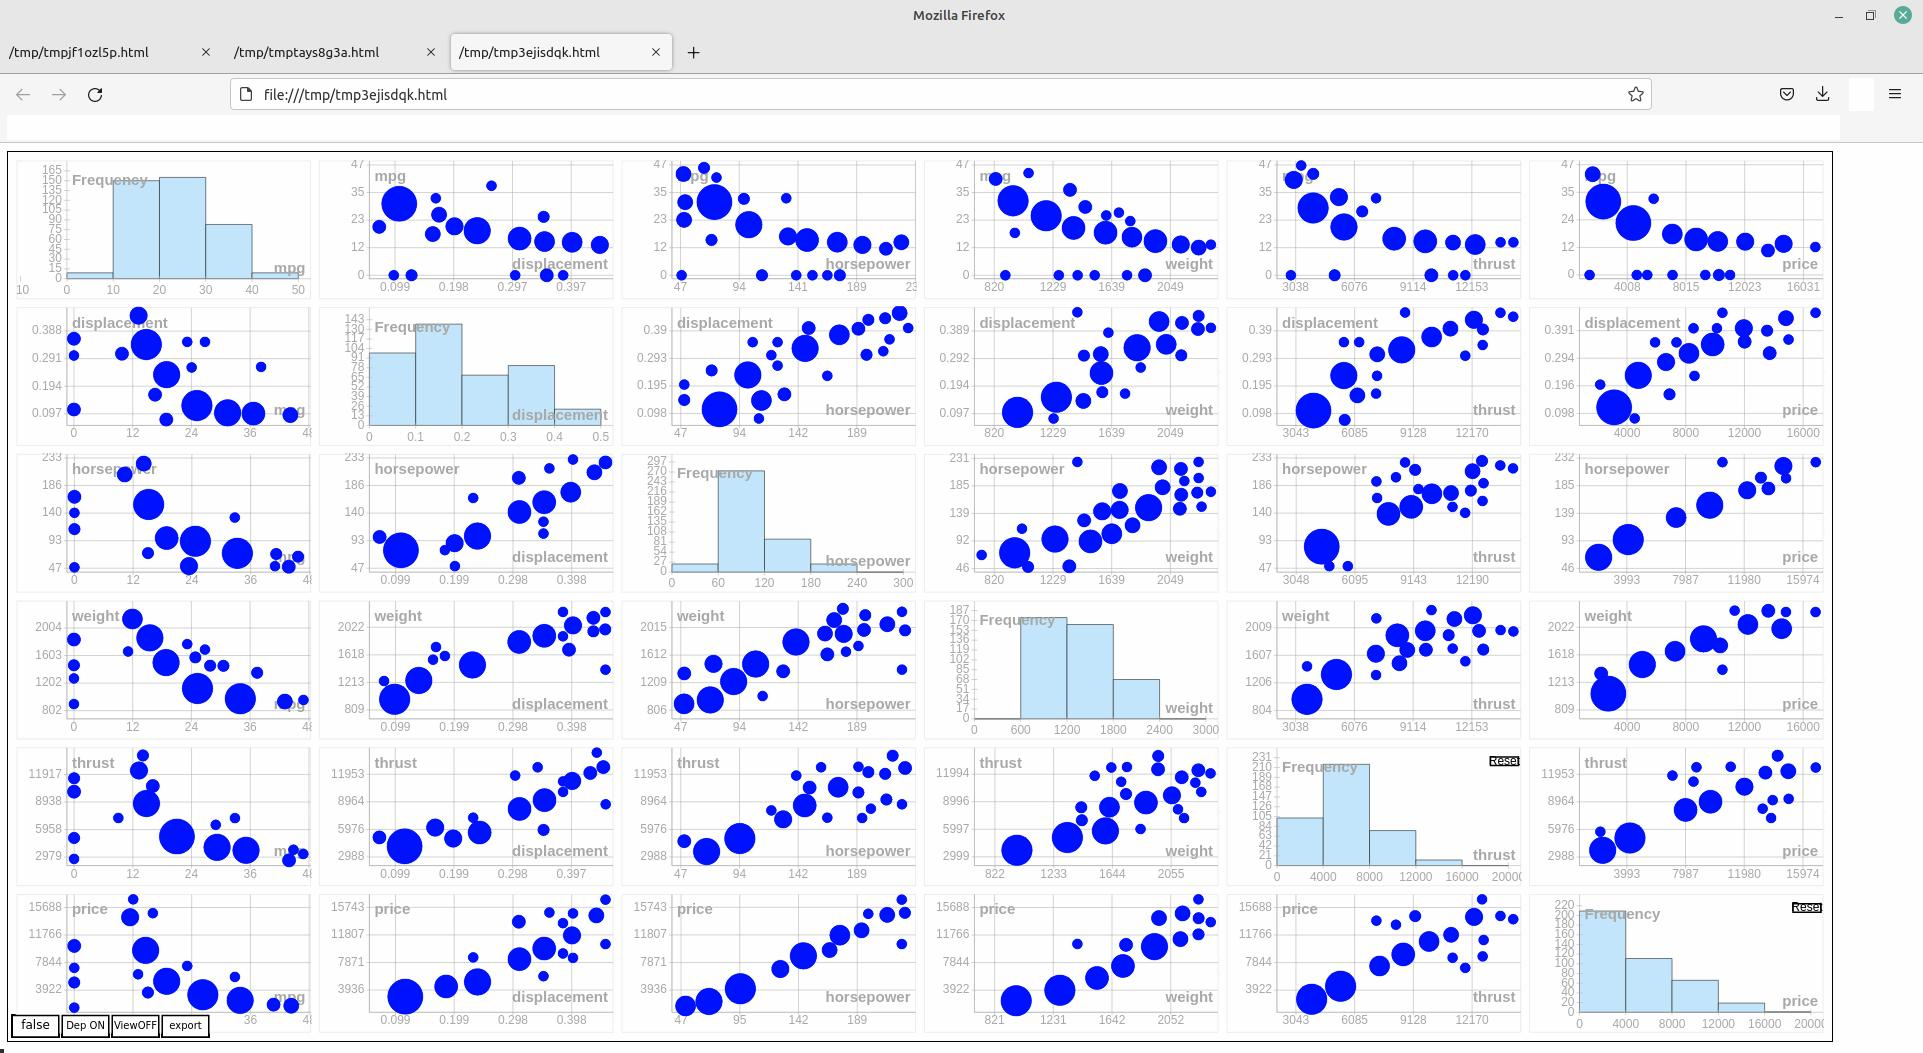

### Dimensionality plot
Plots normalized singular values in a logarithmic diagram. This diagram can be used to highlight the real dimensionality of data which is often lower than the number of considered features. In this case, real dimensionality of data is the same as the number of features.

In general, dimensionality of data is equal to the rank of their matrix.

For more information, see [the singular values documention](https://faire lien).

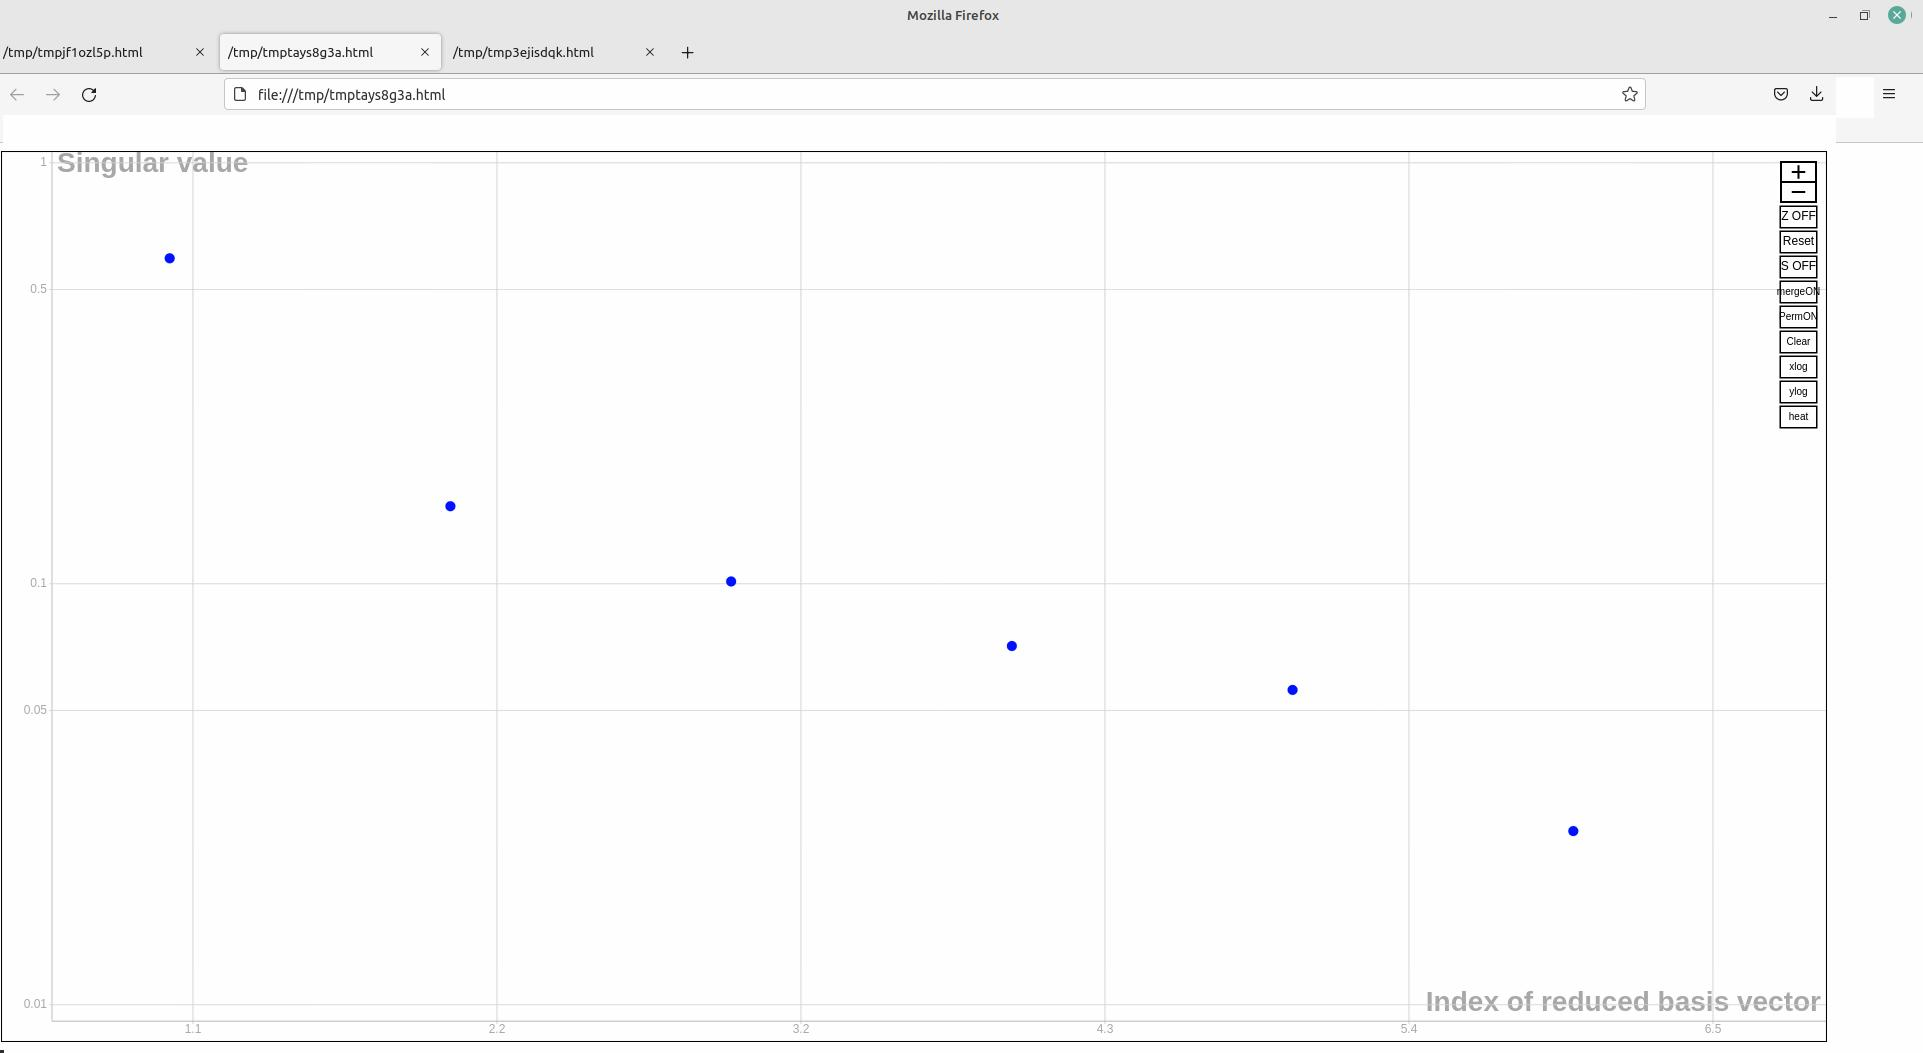

## Build equivalent workflow
The previous process can be instantiated in a workflow and ran on platform. For the sake of simplicity, the `Car` class used in what follows is the standard one available in `dessia_common.tests`, present in the platform database. 

Firstly, import the csv file of all available cars, write the following code:

In [ ]:
import pkg_resources

# Import file
csv_cars = pkg_resources.resource_stream('dessia_common', 'models/data/cars.csv')
stream_file = StringFile.from_stream(csv_cars)

Then, write the code to create the required workflow blocks: 

1.   One `ClassMethod` block for loading cars in a list
2.   One `InstantiateModel` block for pushing the list of cars as `dessia_objects` in a new HeterogeneousList

Link them with a pipe and create the corresponding workflow.




In [ ]:
from dessia_common.typings import ClassMethodType
from dessia_common.workflow.blocks import ClassMethod, InstantiateModel
from dessia_common.workflow.core import Workflow, Pipe

# Create blocks
load_car_block = ClassMethod(method_type=ClassMethodType(Car, 'from_csv'), name='CSV Cars')
hlist_block = InstantiateModel(model_class=HeterogeneousList, name='HList Cars')
blocks = [load_car_block, hlist_block]

# Create pipe
pipe = Pipe(load_car_block.outputs[0], hlist_block.inputs[0])

# Create workflow
workflow = Workflow(blocks, [pipe], output=hlist_block.outputs[0], name='Demo HList')

Check the generated workflow by typing `workflow.plot()`:
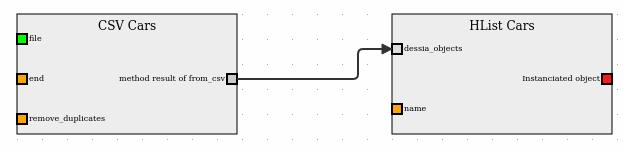


# Create elementary generator & optimizer


## Create a class Optimizer

After coding all these classes and methods, we can make up our minds on how to optimize a reductor. First of all, let's add a new class called "Optimizer" in the core.py file. This class takes the reductor and every requirement the system is expected to meet as inputs. In our case, those are the speed_output and the box limitation. The box limitation is defined by the two tuples x_min_max and y_min_max.

## How to optimize?

The optimization is done by the "minimize" function imported from scipy.optimize. This function returns the arguments needed to minimize an objective function based on several criteria and conditions, using the gradient descend procedure. A good optimization relies on a "good" objective function. The closer to 0 the objective function, the better the optimization, the better the reductor meets its requirements. You can see the inputs and outputs of this function on this link (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

## Defining the x vector

The "minimize" function needs a x vector that specifies the parameters to optimize. In our tutorial, those are the x and y positions of every shaft and the diameter of one gear in all the meshes. The two gears are not needed as arguments as the diameter of the second gear is deduced from the first gear's diameter and the shaft. As a result, the vector x is composed of 8 elements, the 6 first are the positions x and y of the 3 shafts and the 2 last are the diameters of the 2 meshes' first gears.

## Defining the bounds of the optimization

We also have to create a "bounds" vector to bound (define min and max) of all the parameters of the x vector. In our case, the minimum and the maximum of the shaft's x and y positions are the parameters x_min_max and y_min_max. As for the two gears' diameters, the shaft's diameter is taken as the minimum and the diagonal of the box as the maximum. This bounds vector will be initialized in the "init" because we need it to use the "minimize" function but also to create an initialization vector.

In [ ]:
class Optimizer(DessiaObject):
    _non_serializable_attributes = ['bounds']
    def __init__(self, reductor: Reductor, speed_output: float, x_min_max: Tuple[float, float], y_min_max: Tuple[float, float], name: str =''):
        self.reductor = reductor
        self.x_min_max = x_min_max
        self.y_min_max = y_min_max
        self.speed_output = speed_output
        DessiaObject.__init__(self,name=name)

        bounds = []
        for shaft in reductor.shafts:
            bounds.append([x_min_max[0], x_min_max[1]])
            bounds.append([y_min_max[0], y_min_max[1]])
        for mesh in reductor.meshes:
            bounds.append([mesh.gear1.shaft.diameter, ((y_min_max[1]-y_min_max[0])**2 + (x_min_max[1]-x_min_max[0])**2)**(1/2)])
        self.bounds = bounds

## How to choose and construct the initial conditions of an optimization?

The last parameter needed to use the "minimize" function is an initial x vector. This parameter is very important because the result of the optimization depends on it. Two optimizations can have different results if their initial vectors are different. A good pratice is to always create a function that builds the initial vector as settling the best one is sometimes tricky. This function calculates an "acceptable" initial vector from the random one by making it converging to an "acceptable" vector after each loop.

In this tutorial, the "random" function of numpy's "random" module is used. The command float(npy.random.random(1)) returns a random number between 0 and 1. We just have to multiply this random number by the difference between the min and the max of the bounds and add the minimum for all the bounds to construct our initialization vector.

In [ ]:
def cond_init(self):
    x0 = []
    for interval in self.bounds:
        x0.append((interval[1]-interval[0])*float(npy.random.random(1))+interval[0])
    return x0

Optimizer.cond_init = cond_init

## Construct an update function in your objects

Now, let's build the objective function. The only rule is to set the x vector as its first input.

As for the function's body, the first thing to do is updating the reductor's parameters with the x vector. These parameters will change during the optimization. When a method from the reductor class is called, you have to make sure your object is up-to-date, ie is updated with the newest x vector.

This update function will be coded in the reductor class. The input of this function is the x vector, and we just have to assign the parameters of this vector to the right objects and arguments. The 6 first parameters are the x and y positions of the shafts, in their respective order. The 2 last are the meshes first gear's diameters, in their respective order too. The diameters of the other gears and meshes are deduced from their their centers' distances.

In [ ]:
def update(self, x):
    i=0
    for shaft in self.shafts:
        shaft.pos_x=x[i]
        shaft.pos_y=x[i+1]
        i+=2
    for mesh in self.meshes:
        shaft_gear1=mesh.gear1.shaft
        shaft_gear2=mesh.gear2.shaft
        center_distance = ((shaft_gear1.pos_x-shaft_gear2.pos_x)**2+(shaft_gear1.pos_y-shaft_gear2.pos_y)**2)**(1/2)

        mesh.gear1.diameter = x[i]
        mesh.gear2.diameter = (center_distance-x[i]/2)*2
        i += 1

Reductor.update = update

## Build the objective function and add a speed specification in the optimization

Now, let's set up the specifications that the reductor is going to meet. Just as a reminder, the optimization is done when the objective function reaches a value near 0. So we just need to substract the current speed (calculated by the reductor's function) from the objective speed (the one in the Optimizer's init) and add the result to the parameter that objective function returns. In the tutorial, we call this parameter "functional", and this parameter must be always positive. If functional<0, the optimization fails.

Another thing that you can add to the condition check is a power/an exponent. The higher the power, the more important the slope of the function, the quicker the "minimize" function will find an optimized result. In this tutorial, we chose to add a power of 2 to the operations but this is something you can change.

In [ ]:
def objective(self, x):
    self.reductor.update(x)
    speed = self.reductor.speed_output()
    functional = 0

    # Optimization of output speed
    functional += (self.speed_output- speed)**2

    return functional

Optimizer.objective = objective

## Construct an optimization into a function

For now, let's do a test using this condition in the objective function. Before that, we have to create an "optimize" function in the optimizer class that calls the "minimize" function but also the while loop with the initialization vector that we randomly choose (the function cond_init). This step, which consists in choosing the conditions, is a milestone that determines whether the optimization will be successful or not. The "success" output of the "minimize" function helps us know if the optimization encountered problems or not. Moreover, a "precision" parameter has to be set (which corresponds to the "fun" parameter of the resulting object). In our case there is only one specification, and we can say that an optimization is successful if the objective result is inferior to 1e-5 (the smaller the precision, the longer it takes to process the optimization).

Furthermore, a "max_loops" parameter is added, in case the precision is too small and the "success" is too hard to reach.

Finally, when an optimized result is found, the x vector has to be updated one last time. Otherwise, the current x vector might not be the finest one.

In [ ]:
def optimize(self, max_loops=1000):
    valid = True
    count = 0
    while valid and count < max_loops:
        x0 = self.cond_init()
        self.reductor.update(x0)
        res = minimize(self.objective, x0, bounds=self.bounds)
        count += 1
        if  res.fun<1e-5 and res.success:
            self.reductor.update(res.x)
            valid = False
            return self.reductor
    return self.reductor

Optimizer.optimize = optimize

# Script

For the test, we have to code a script in another file called "scripts.py". In this file, you have to create a reductor object, use it to initialize an optimizer object and launch the optimize function. The diameters values are not important because they will change during the optimization. (We set it to 0 and 0.1). You can choose whatever you want as inputs of the motor and the specifications parameters of the optimizer.

In [ ]:
def script_optimize():
    motor = Motor(diameter=0.1, length=0.2, speed=120)
    shafts = [Shaft(pos_x=0, pos_y=0, length=0.1), Shaft(pos_x=0, pos_y=0, length=0.1), Shaft(pos_x=0, pos_y=0, length=0.1)]
    meshes = []
    for j, shaft in enumerate(shafts) :
        if j == 1:
            gear1 = Gear(diameter=0.1, length=0.01, shaft=shaft)
            gear2 = Gear(diameter=0.1, length=0.01, shaft=shaft)
            meshes.append(Mesh(gear, gear1))
        else:
            gear = Gear(diameter=0.1, length=0.01, shaft=shaft)
    meshes.append(Mesh(gear2, gear))
    reductor = Reductor(motor, shafts, meshes)


    optimizer = Optimizer(reductor=reductor, speed_output=500, x_min_max=[-1,1], y_min_max=[-1,1])
    optimizer.optimize()
    return reductor


If you run this script, and use the function babylonjs on the reductor you will be shown a 3D representation.

In [ ]:
reductor = script_optimize()

# Jupyter Notebook usage
reductor.save_babylonjs_to_file(filename='/tmp/reductor3d')
HTML(filename='/tmp/reductor3d.html')

*Adding a position specification*

By calling the reductor's speed_output function, you can easily check that the speed condition is verified. However, you'll notice that the gears are way too big, which is not surprising since the box limits have not been set as specifications in the objective function.

In order to do that, we have to verify for each gears if their positions + their diameters/2 are inside the box. If a gear is outside of the box, we add the difference between the limit of the box and the position + the diameter/2 of the gear to the functional variable (raised to the power 2). We have to do that for all the borders of the box (one condition for each borders).

In [ ]:
def objective(self, x):
    self.reductor.update(x)
    speed = self.reductor.speed_output()
    functional = 0

    # Optimization of output speed
    functional += (self.speed_output- speed)**2

    for mesh in self.reductor.meshes:
        for gear in [mesh.gear1,mesh.gear2]:

            # Optimization of surface
            if gear.shaft.pos_x-gear.diameter/2 < self.x_min_max[0]:
                functional += (gear.shaft.pos_x-gear.diameter/2-self.x_min_max[0])**2

            if gear.shaft.pos_x+gear.diameter/2 > self.x_min_max[1]:
                functional+= (gear.shaft.pos_x-gear.diameter/2-self.x_min_max[1])**2

            if gear.shaft.pos_y-gear.diameter/2 < self.y_min_max[0]:
                functional += (gear.shaft.pos_y-gear.diameter/2-self.y_min_max[0])**2

            if gear.shaft.pos_y+gear.diameter/2 > self.y_min_max[1]:
                functional += (gear.shaft.pos_y-gear.diameter/2-self.y_min_max[1])**2

    return functional

Optimizer.objective = objective

*Adding an optimization on the mass*

The box conditions are satisfied now, the last specification that we have to add is the mass optimization. For that, we just have to add the mass to the functional variable. However, this time we add a real parameter to the functional variable and not a difference. The mass parameter will never be equal to 0. The objective is to find the smallest value. Moreover, this parameter can interfere with the other specifications in the objective function. If this parameter is too high, the optimization will reduce this parameter without taking into account of the other conditions. But if this parameter is too small, the optimization might lack precision. As we are facing a dilemma, the specifications have to be sorted in the range of importance. In this tutorial, we chose to put the mass specification first, that's why we only added 1/10 of the mass to functional variable. You can try another distribution of importance between the specifications by dividing by another value. 

In [ ]:
def objective(self, x):
    self.reductor.update(x)
    speed = self.reductor.speed_output()
    functional = 0

    # Optimization of output speed
    functional += (self.speed_output- speed)**2

    for mesh in self.reductor.meshes:
        for gear in [mesh.gear1,mesh.gear2]:
            
            # Optimization of surface
            if gear.shaft.pos_x-gear.diameter/2 < self.x_min_max[0]:
                functional += (gear.shaft.pos_x-gear.diameter/2-self.x_min_max[0])**2

            if gear.shaft.pos_x+gear.diameter/2 > self.x_min_max[1]:
                functional+= (gear.shaft.pos_x-gear.diameter/2-self.x_min_max[1])**2

            if gear.shaft.pos_y-gear.diameter/2 < self.y_min_max[0]:
                functional += (gear.shaft.pos_y-gear.diameter/2-self.y_min_max[0])**2

            if gear.shaft.pos_y+gear.diameter/2 > self.y_min_max[1]:
                functional += (gear.shaft.pos_y-gear.diameter/2-self.y_min_max[1])**2
                
    # Optimization of mass
    functional += self.reductor.mass()/10

    return functional

Optimizer.objective = objective

Also, the precision might be changed to prevent the algorithm from taking too much time to run, since only 1/10 of the mass is added after each incrementation. Choosing the precision parameter might be difficult, which is why it will be determined by the computer through an algorithm that takes into account the specifications and the box limits.

In [ ]:
def optimize(self, max_loops: int = 1000):
    valid = True
    count = 0
    while valid and count < max_loops:
        x0 = self.cond_init()
        self.reductor.update(x0)
        res = minimize(self.objective, x0, bounds=self.bounds)
        count += 1
        if res.fun < 10 and res.success:
            print(f'Solution found: count = {count}, cost function = {res.fun}')
            self.reductor.update(res.x)
            valid = False
            return self.reductor

    return self.reductor

Optimizer.optimize = optimize

If you run the script again, you will see that the size of the gear is smaller now.

In [ ]:
reductor = script_optimize()

# Jupyter Notebook usage
reductor.save_babylonjs_to_file(filename='/tmp/reductor3d')
HTML(filename='/tmp/reductor3d.html')

Solution found: count = 5, cost function = 0.7458109987330523


*Other examples of adding a specification*

Now, all the specifications are met by the objective function. However, there are still some minor issues. For example, you can have the following type of problem where the diameter of the mesh's second gear is inferior to the diameter of the shaft: 

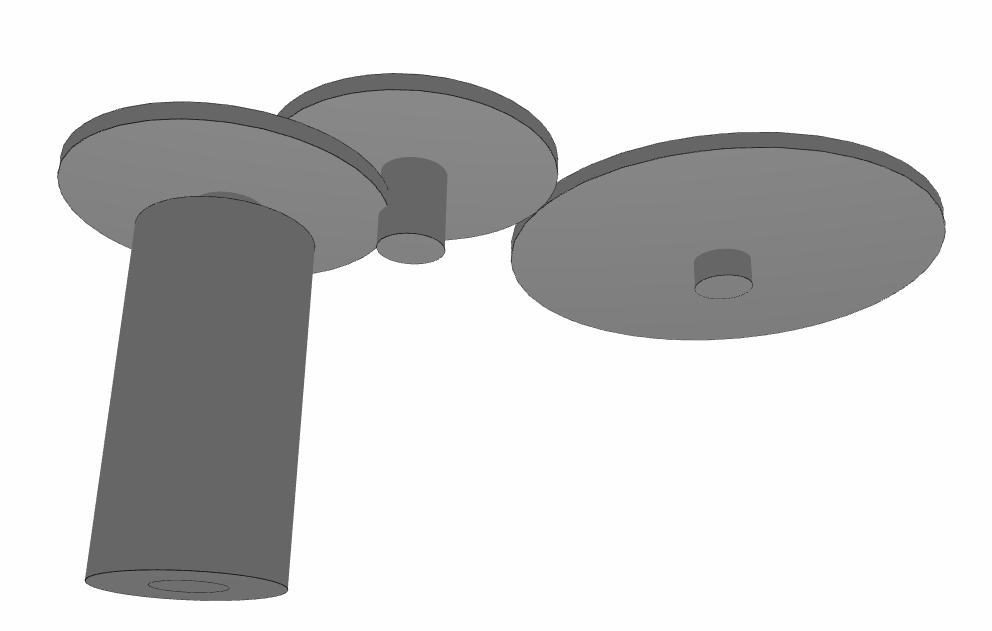

It's not a surprise as we have bounded the mesh first gear's diameter only. To solve this problem, we can add a condition in the objective function. In that case, it would not be a matter of reaching an objective, but something that the optimizer doesn't do. Thus, we can add a fixed value to the "functional" variable as long as the condition isn't verified, which is equal to 10 in our example. This will avoid the solutions from having this kind of issue.

In [ ]:
def objective(self, x):
    self.reductor.update(x)
    speed = self.reductor.speed_output()
    functional = 0

    # Optimization of output speed
    functional += (self.speed_output- speed)**2
    for mesh in self.reductor.meshes:

        # Optimization of collisions 
        if mesh.gear2.diameter<mesh.gear2.shaft.diameter:
              functional += 10

        for gear in [mesh.gear1,mesh.gear2]:
            # Optimization of surface
            if gear.shaft.pos_x-gear.diameter/2 < self.x_min_max[0]:
                functional += (gear.shaft.pos_x-gear.diameter/2-self.x_min_max[0])**2

            if gear.shaft.pos_x+gear.diameter/2 > self.x_min_max[1]:
                functional+= (gear.shaft.pos_x-gear.diameter/2-self.x_min_max[1])**2

            if gear.shaft.pos_y-gear.diameter/2 < self.y_min_max[0]:
                functional += (gear.shaft.pos_y-gear.diameter/2-self.y_min_max[0])**2

            if gear.shaft.pos_y+gear.diameter/2 > self.y_min_max[1]:

                functional += (gear.shaft.pos_y-gear.diameter/2-self.y_min_max[1])**2

    # Optimization of mass
    functional += self.reductor.mass()/10

    return functional

Optimizer.objective = objective

The optimizer is done now, but you can still go further and add some additional conditions to the objective function. For example, you can try to avoid collisions between shafts and gears. In our tutorial, the distance between shafts is set avoid collisions but changing lengths may create this kind of problems in some solutions:

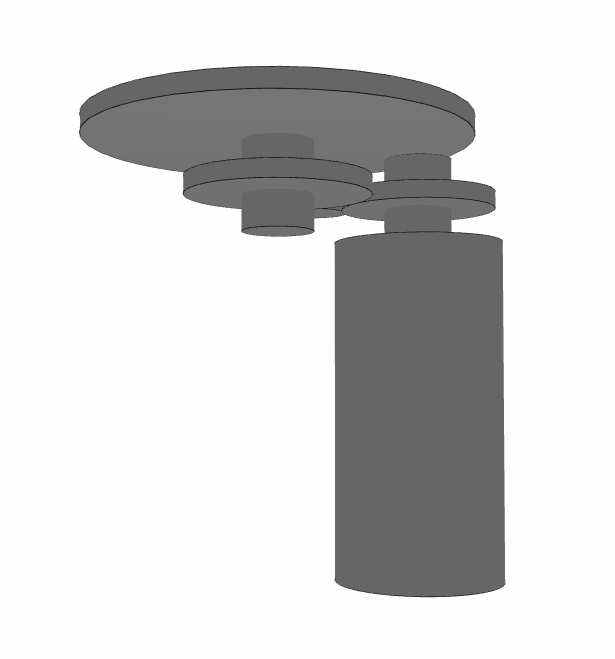

Provided that you deeply understood how the optimization works and how the objects are structured, that may be a good exercise. In addition, all the solutions will be collision-free.

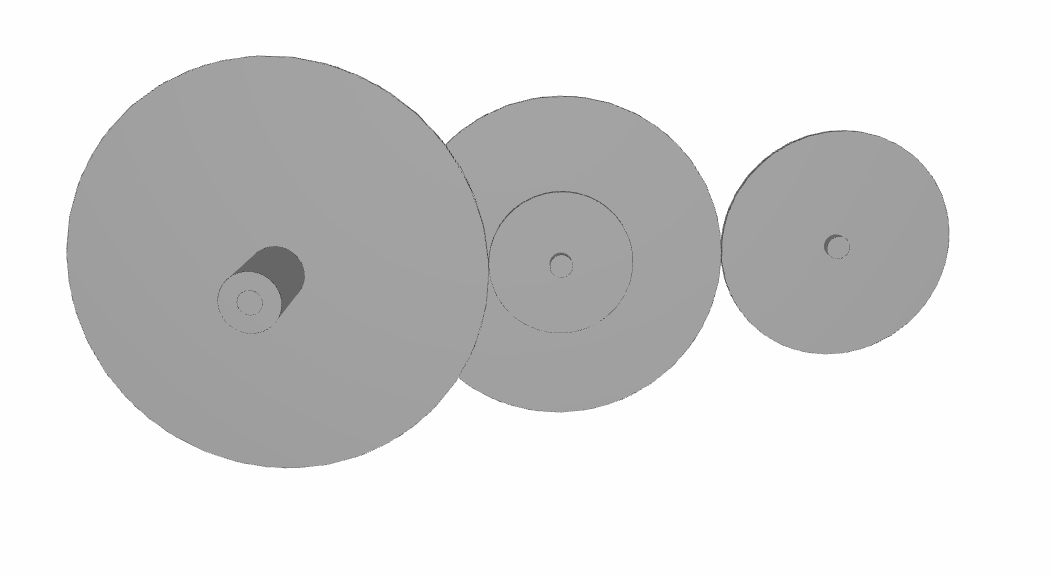

# Build your workflow


## Create a workflow for an optimizer

This part is about building a good workflow from the optimizer. The first step consists in transforming the Optimizer object into workflow blocks.

In [ ]:
import dessia_common.workflow as wf

block_optimizer = wf.InstantiateModel(Optimizer, name='Optimizer')
method_optimize = wf.MethodType(class_=Optimizer,  name='optimize')
block_optimize = wf.ModelMethod(method_type=method_optimize, name='Optimize')

Next, a reductor is needed for the optimization. However, instantiating all the gears and shafts is neither convenient, nor in the workflow's logic. Moreover, all the diameters and lengths are determined in the optimizer. Therefore, the only parameters that the user needs to choose are the motor and the optimizer's parameters as well as the length of the gears. Thus, a good way to overcome this problem to create an InstantiateReductor class that only needs a motor and a gear length to instantiate a reductor. Its "instanciate" method returns a reductor by automatically creating all the gears, meshes and shafts. This improvement makes the workflow much more user-friendly.

In [ ]:
class InstanciateReductor(DessiaObject):

    def __init__(self,motor: Motor, length_gears: float = 0.01, name: str = ''):
        self.motor=motor

        self.length_gears=length_gears
        DessiaObject.__init__(self,name=name)


    def instanciate(self):
        shafts = [Shaft(pos_x=0, pos_y=0, length=0.1), Shaft(pos_x=0, pos_y=0, length=0.1),
                  Shaft(pos_x=0, pos_y=0, length=0.1)]
        meshes = []
        for j, shaft in enumerate(shafts) :
            if j == 1:
                gear1 = Gear(diameter=0.1, length=self.length_gears, shaft=shaft)
                gear2 = Gear(diameter=0.1, length=self.length_gears, shaft=shaft)
                meshes.append(Mesh(gear, gear1))
            else:
                gear = Gear(diameter=0.1, length=self.length_gears, shaft=shaft)
        meshes.append(Mesh(gear2, gear))
        reductor = Reductor(self.motor, shafts, meshes)
        return reductor


Now, let's create the workflow blocks for the "InstanciateReductor" class and for the "InstantiateModel" method.

In [ ]:
block_instanciate_reductor = wf.InstantiateModel(InstanciateReductor, name='Instanciate Reductor')
method_instanciate = wf.MethodType(class_=InstanciateReductor, name='instanciate')
block_instanciate = wf.ModelMethod(method_type=method_instanciate, name='Instanciate')

A motor has to be instiantiated as well, thus needs a specific workflow block.

In [ ]:
block_motor=wf.InstantiateModel(Motor, name='Motor')


At this point, the only step remaining is to create the workflow and to connect them. Running the code and plotting the workflow using "workflow.plot()" should display the following result:

In [ ]:
block_workflow = [block_optimizer, block_optimize, block_instanciate_reductor, 
                  block_instanciate, block_motor]

pipe_worflow = [wf.Pipe(block_optimizer.outputs[0], block_optimize.inputs[0]),
                wf.Pipe(block_instanciate_reductor.outputs[0], block_instanciate.inputs[0]),
                wf.Pipe(block_motor.outputs[0], block_instanciate_reductor.inputs[0]),
                wf.Pipe(block_instanciate.outputs[0], block_optimizer.inputs[0])]

workflow = wf.Workflow(block_workflow, pipe_worflow, block_optimize.outputs[0])

In [ ]:
# Colab users
import json
import tempfile
from dessia_common.templates import workflow_template
data = json.dumps(workflow.jointjs_data())
rendered_template = workflow_template.substitute(workflow_data=data)

temp_file = tempfile.mkstemp(suffix='.html')[1]
with open(temp_file, 'wb') as file:
    file.write(rendered_template.encode('utf-8'))
HTML(filename=temp_file)

# Other users
# workflow.plot()

As for the inputs values of the workflow, the "optimizer" block has 3 inputs (1: speed_output, 2: x_min_max, 3: y_min_max), the "instanciate_reductor" block has 1 input (1: length of the gears) and the "motor" block has 3 inputs (0: diameter, 1: length, 3: speed_input).

In [ ]:
input_values = {workflow.index(block_optimizer.inputs[1]): 500,
                workflow.index(block_optimizer.inputs[2]): [-1,1],
                workflow.index(block_optimizer.inputs[3]): [-1,1],

                workflow.index(block_instanciate_reductor.inputs[1]): 0.01,

                workflow.index(block_motor.inputs[0]): 0.1,
                workflow.index(block_motor.inputs[1]): 0.2,
                workflow.index(block_motor.inputs[2]): 150          
                }

If you run the workflow, you should get a reductor in result. If the platform runs, you can also import the workflow run to see its plot on the platform. The reductor's "standalone_in_db" attribute must be True.

In [ ]:
!pip install dessia_api_client

from dessia_api_client.clients import PlatformApiClient
from dessia_api_client.endpoints.objects import ObjectsEndPoint

workflow_generator_run = workflow.run(input_values)

pac = PlatformApiClient(
    email='enter@your.email',
    password='***********',
    api_url='https://api.platform-dev.dessia.tech')
c = ObjectsEndPoint(pac)
#r = c.create_object_from_python_object(workflow_generator_run)
#print(r, r.text)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Solution found: count = 3, cost function = 7.384416109150502


Here is the result on the platform:

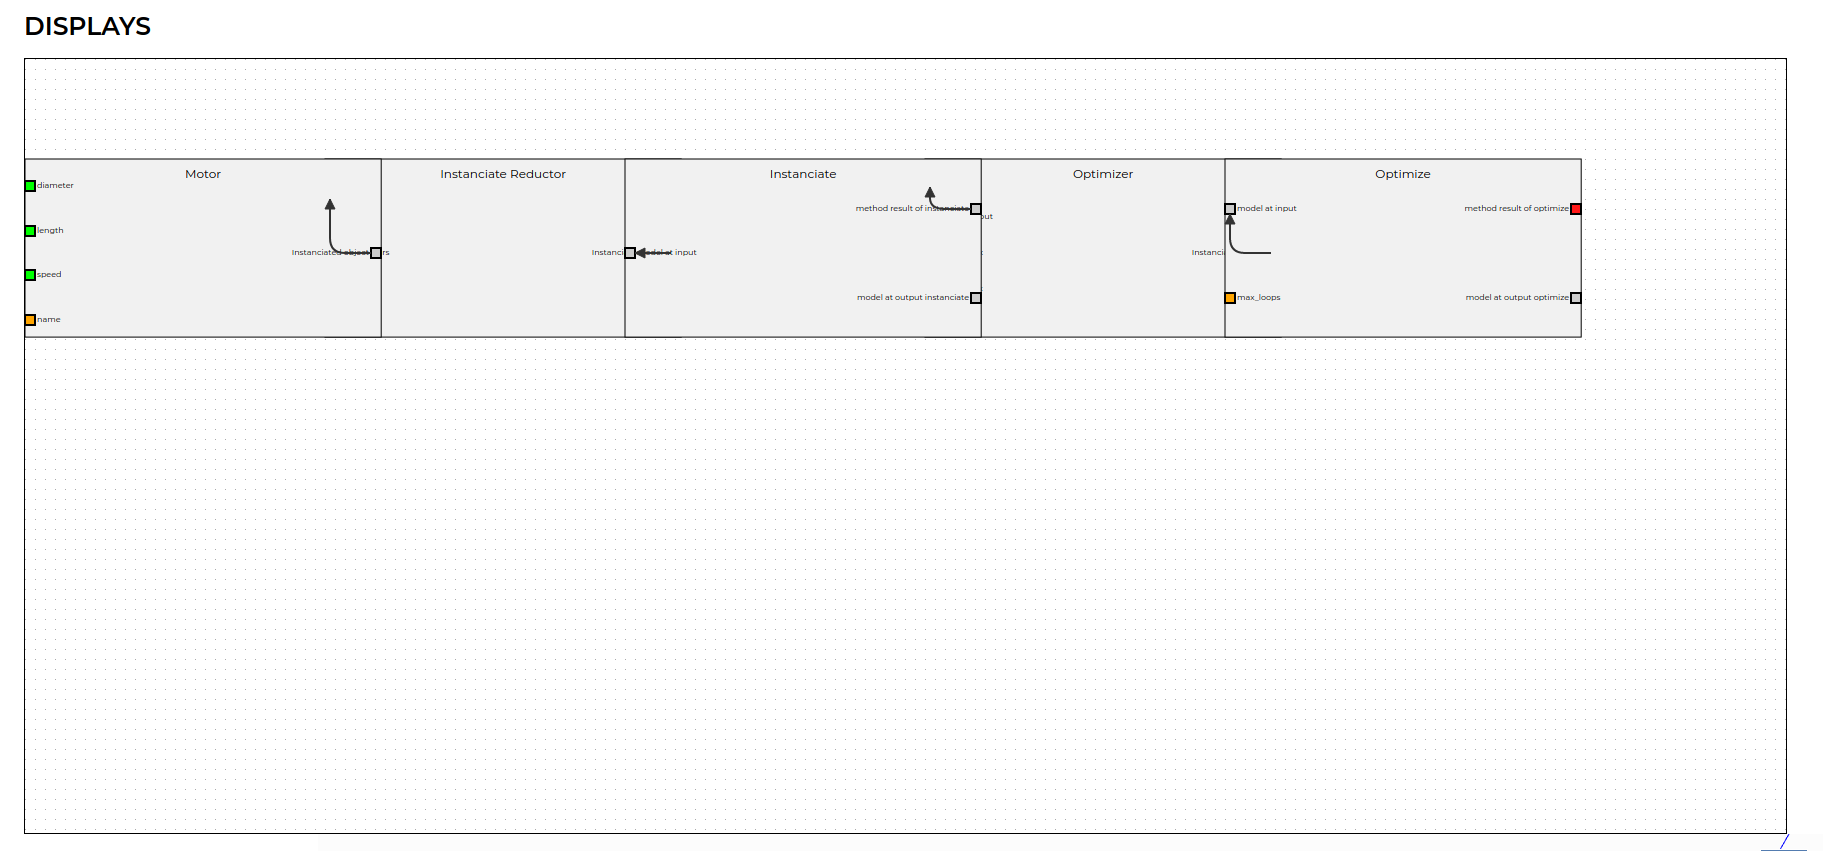

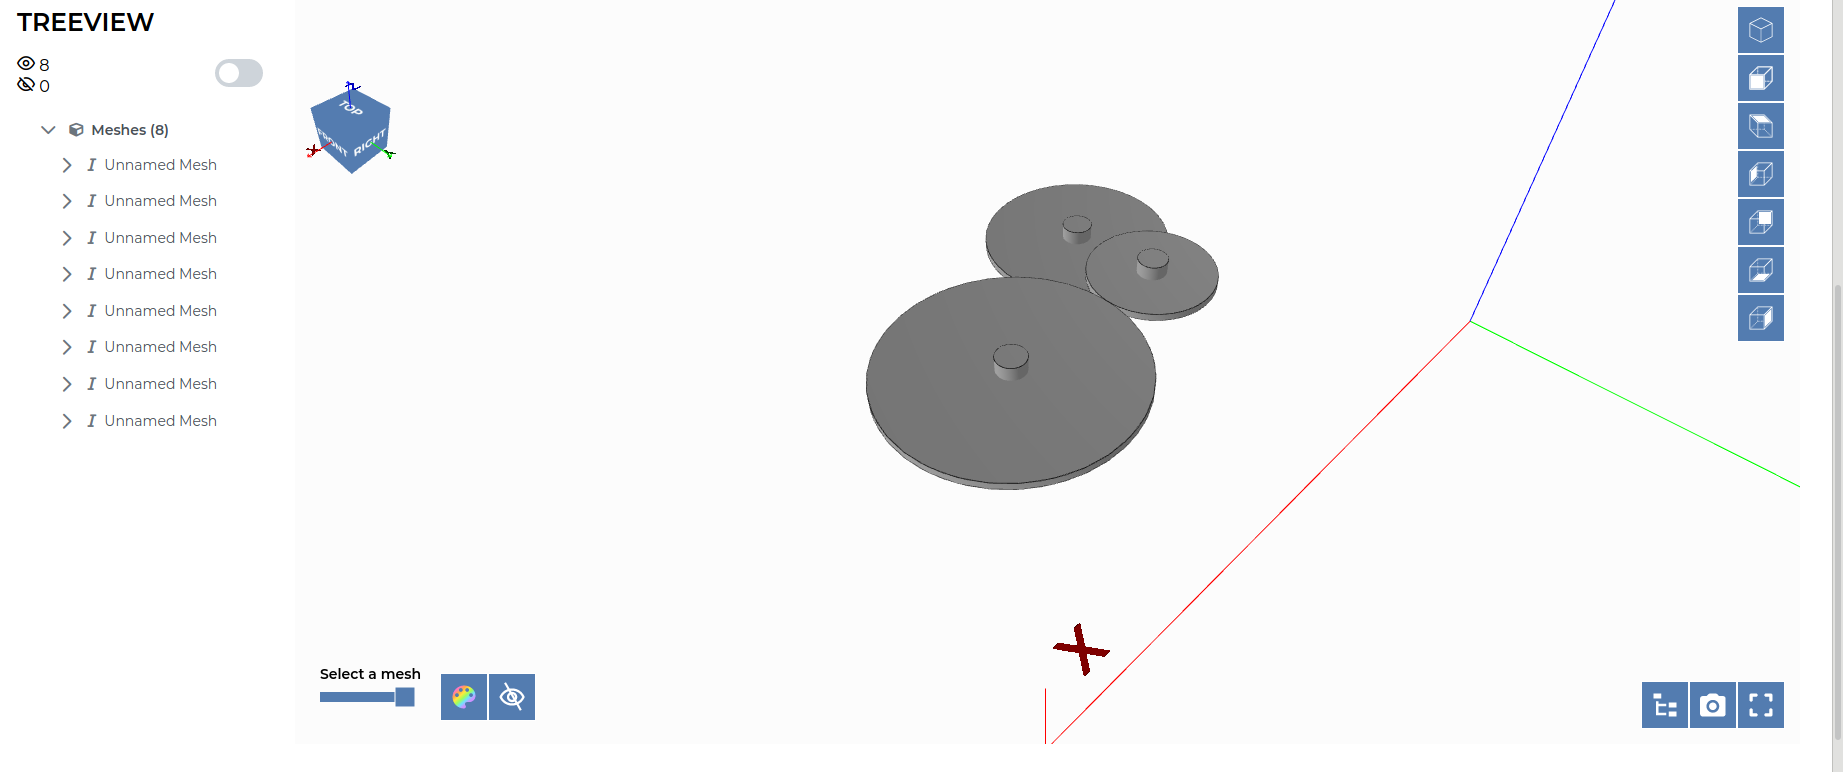

## Plot more solutions in an optimizer

The workflow is on top of the page and the optimization on the bottom. In this example, there is only one optimized solution in the output. A few changes in the code are needed in order to compare the different optimizations. Firstly, we need to change the return of the optimize method. We remove the first return in the while loop and replace it by an add of a deep copy of the reductor in a list list_reductor, that we defined at the beginning of the method. The last return will now return the list_reductor and not just the reductor. The optimize function return now a list of solutions optimized.

First of all, the output of the "optimize" method has to change.

In [ ]:
def optimize(self, max_loops: int = 1000):
    valid = True
    count = 0
    list_reductor = []
    while valid and count < max_loops:
        x0 = self.cond_init()
        self.reductor.update(x0)
        res = minimize(self.objective, x0, bounds=self.bounds)
        count += 1
        if  res.fun < 10 and res.success:
            print(f'Solution found: count = {count}, cost function = {res.fun}')
            self.reductor.update(res.x)
            list_reductor.append(copy.deepcopy(self.reductor))
    return list_reductor

Optimizer.optimize = optimize

## Add parameters to compare the results of an optimization

Secondly, a few parameters are needed to compare these solutions. This may be the mass, which has already been calculated. But it needs to be declared as the Reductor class' attribute. That's why a new "mass" attribute is introduced. It stores the mass() method's output. This parameter has to get updated when using the optimizer.

In [ ]:
def __init__(self, motor: Motor, shafts: List[Shaft], meshes: List[Mesh], name: str = ''):
    self.shafts = shafts
    self.meshes = meshes
    self.name = name
    self.motor = motor
    self.offset = 0.02
    DessiaObject.__init__(self,name=name)
    self.mass = self.mass()

Reductor.__init__ = __init__

def update(self, x):
    i=0
    for shaft in self.shafts:
        shaft.pos_x = x[i]
        shaft.pos_y = x[i+1]
        i+=2
    for mesh in self.meshes:
        shaft_gear1=mesh.gear1.shaft
        shaft_gear2=mesh.gear2.shaft
        center_distance = ((shaft_gear1.pos_x-shaft_gear2.pos_x) ** 2
                           + (shaft_gear1.pos_y-shaft_gear2.pos_y) ** 2) ** 0.5

        mesh.gear1.diameter = x[i]
        mesh.gear2.diameter = (center_distance-x[i]/2)*2
        i += 1
    self.mass = self.mass()

Reductor.update = update

At your convenience, you can add other parameters to compare these solutions. Another parameter that we add is number_solution, equal to the position of the reductor in list_reductor. That will help have a good plot of the solutions in the ParallelPlot display. To do so, we add the attribute to init and update it in the optimize method.

The number of displayed solutions may also be an interesting parameter as it prevents the plot from displaying too much solutions. Let's define a parameter named "number_solution" and add it to the "optimize" function.

In [ ]:
def __init__(self, motor: Motor, shafts: List[Shaft], meshes: List[Mesh], number_solution: int = 0,name: str = ''):
    self.shafts = shafts
    self.meshes = meshes
    self.name = name
    self.motor = motor
    self.offset = 0.02
    self.number_solution = number_solution
    DessiaObject.__init__(self,name=name)
    self.mass = self.mass()

Reductor.__init__ = __init__

def optimize(self, max_loops: int = 1000):
    valid = True
    count = 0
    list_reductor = []
    while valid and count < max_loops:
        x0 = self.cond_init()
        self.reductor.update(x0)
        res = minimize(self.objective, x0, bounds=self.bounds)
        count += 1
        if  res.fun < 10 and res.success:
            print(f'Solution found: count = {count}, cost function = {res.fun}')
            self.reductor.update(res.x)
            self.reductor.number_solution = len(list_reductor)
            list_reductor.append(copy.deepcopy(self.reductor))
    return list_reductor

Optimizer.optimize = optimize

## Construct a MultiPlot for optimization

Parameters "mass" and "number_solution" are added in "list_attributes" to get the corresponding block in our workflow.

In [ ]:
list_attribute1 = ['mass_reductor','number_solution']
display_reductor = wf.MultiPlot(attributes=list_attribute1, order=1, name='Display Reductor')

block_workflow = [block_optimizer, block_optimize, block_instanciate_reductor,
                  block_instanciate, block_motor, display_reductor]

pipe_worflow = [wf.Pipe(block_optimizer.outputs[0], block_optimize.inputs[0]),
                wf.Pipe(block_instanciate_reductor.outputs[0], block_instanciate.inputs[0]),
                wf.Pipe(block_motor.outputs[0], block_instanciate_reductor.inputs[0]),
                wf.Pipe(block_instanciate.outputs[0], block_optimizer.inputs[0]),
                wf.Pipe(block_optimize.outputs[0], display_reductor.inputs[0])]

workflow = wf.Workflow(block_workflow, pipe_worflow, block_optimize.outputs[0])

If you run the code again and import your WorkflowRun in the platform, you'll get a similar display, where you can easily compare the mass of the different optimized solutions:

If you run the script again and import the workflow run in the platform, here's the result you should have. In this representation, the masses of the different optimized solutions are easier to compare.

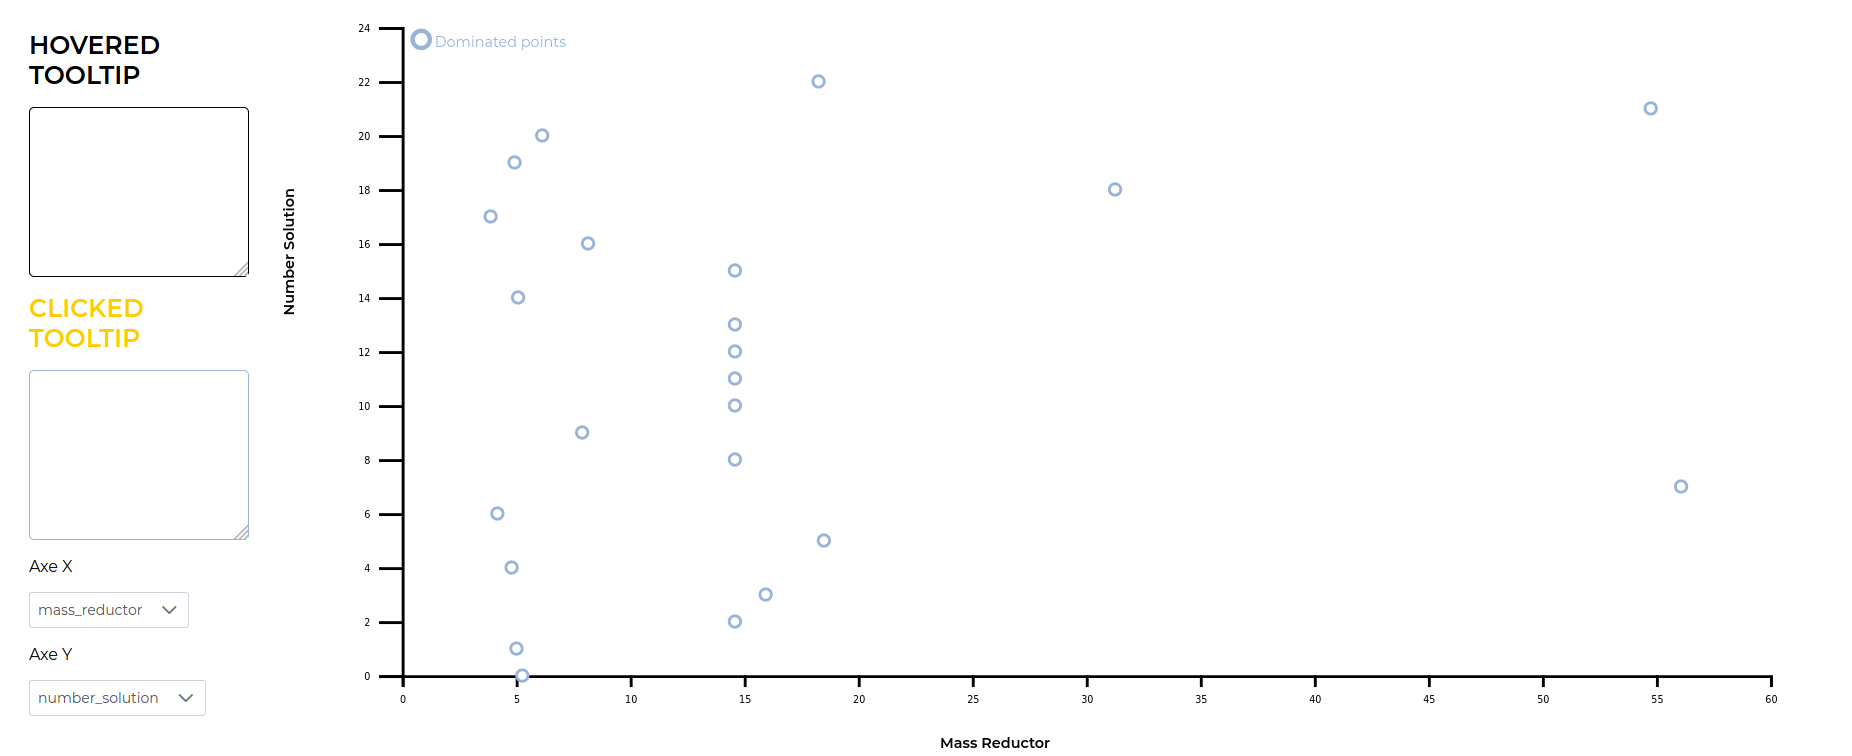

This tutorial now comes to an end, and you should have all the capacities to created your future bot.